## Classify Radio Signals from Space with Keras

### Import Libraries

In [21]:
from livelossplot.inputs.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.1


## Load and Preprocess SETI Data

In [22]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)

val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [23]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [24]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [25]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [26]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Plot 2D Spectrograms

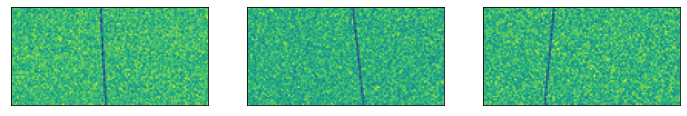

In [27]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

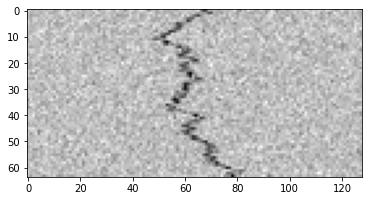

In [28]:
plt.imshow(np.squeeze(x_train[3]), cmap="gray");

## Create Training and Validation Data Generators

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

## Creating the CNN Model

In [30]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [31]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

## Learning Rate Scheduling and Compile the Model

In [32]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

In [33]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 64, 64)       

## Training the Model

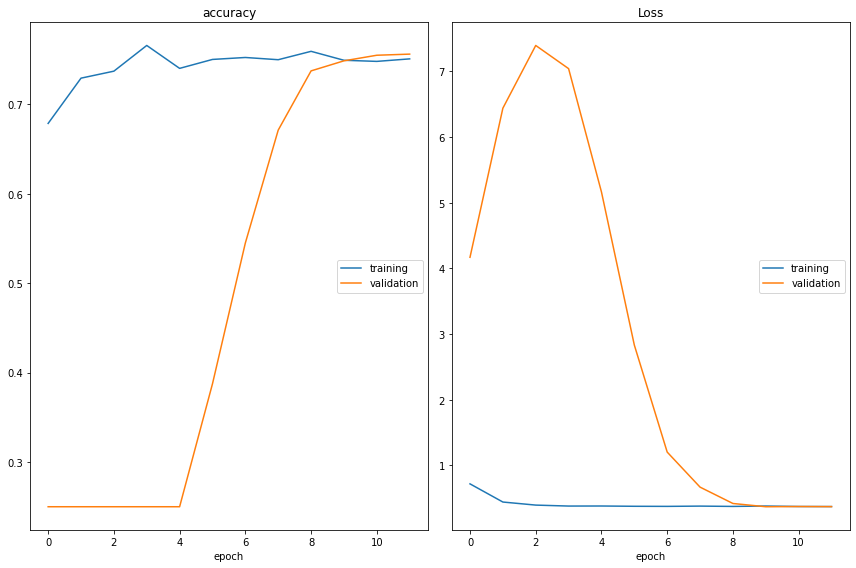

accuracy
	training         	 (min:    0.679, max:    0.766, cur:    0.751)
	validation       	 (min:    0.250, max:    0.756, cur:    0.756)
Loss
	training         	 (min:    0.375, max:    0.720, cur:    0.375)
	validation       	 (min:    0.372, max:    7.396, cur:    0.374)
100/100 [==============================] - 422s 4s/step - loss: 0.3747 - accuracy: 0.7509 - val_loss: 0.3737 - val_accuracy: 0.7563


In [34]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]#, reduce_lr]
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

## Model Evaluation

In [37]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 12s 476ms/step - loss: 0.3737 - accuracy: 0.7700


[0.3737044036388397, 0.7699999809265137]

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.53      0.67      0.59       200
           2       0.56      0.43      0.49       200
           3       1.00      1.00      1.00       200

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800

Classification accuracy: 0.770000


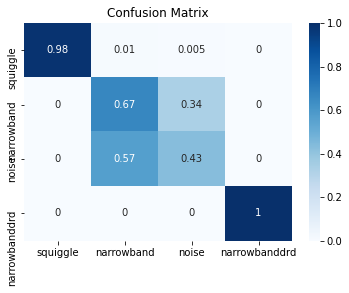

In [40]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);